# Data Mining and Visualisation -- Lab 5

In this lab, you'll explore some basic approaches for regression and classification problems.

First off, we'll load some prerequisites and datasets. These should be starting to look familiar to you now:

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn import linear_model
from scipy import stats
from scipy import optimize

sns.set_theme()
%matplotlib inline


# Load the datasets for today's lab
tips = pd.read_csv("dataset/tips.csv")
mpg = pd.read_csv("dataset/mpg.csv")
titanic = pd.read_csv("dataset/titanic.csv")

In [2]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [3]:
mpg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In [4]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## Regression

Regression analysis gives us a way to understand and quantify relationships between variables through the creation of a regression model. For a simple model with 1 independent variable, this model takes the form of a 'line of best fit':

[Text(0.5, 0, 'Total Bill ($)'), Text(0, 0.5, 'Tip ($)')]

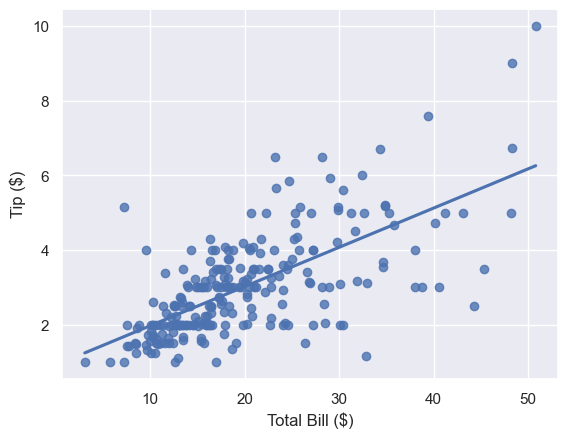

In [2]:
fig = sns.regplot(data=tips, x="total_bill", y="tip", ci=None)
fig.set(xlabel ="Total Bill ($)", ylabel = "Tip ($)")

There are a few different ways we can create a regression model in Python. Let's start with the Scipy Stats module, which is what Seaborn uses:

In [5]:
tips_regression = stats.linregress(tips.total_bill.values, tips.tip.values)

tips_regression

LinregressResult(slope=0.10502451738435338, intercept=0.9202696135546731, rvalue=0.6757341092113646, pvalue=6.692470646863544e-34, stderr=0.007364789848762592, intercept_stderr=0.1597347463764323)

This gives us a linear model as a python object, which we can then use to obtain information about the model:

In [7]:
print("Intercept: ", tips_regression.intercept) 
print("Coefficient (Slope): ", tips_regression.slope)
print("R-squared: ", tips_regression.rvalue**2)
print("Standard Error: ", tips_regression.stderr)

Intercept:  0.9202696135546731
Coefficient (Slope):  0.10502451738435338
R-squared:  0.45661658635167635
Standard Error:  0.007364789848762592


Here we can see that our regression model has an intercept of 0.92 and a slope of 0.11. In other words, for each increase of $1 in our total bill, we can estimate an increase in the amount tipped by $0.11, with a y-intercept of $0.92.

We can also use this information to predict new `tip` values from a `total_bill`: 

$\hat{y} = \beta_{0} + \beta_{1} x_{1} = 0.92 + (0.11 x_{1})$

So with a total_bill of $70, we would expect a tip of:

In [8]:
predicted_tip = tips_regression.intercept + (tips_regression.slope * 70)

print('$', round(predicted_tip, 2))

$ 8.27


Let's look at another way of fitting a linear regression model, this time using `scikit-learn`:

In [6]:
# Note we need to do some reshaping of the data here
tip_lm_x = tips['total_bill'].values.reshape(-1,1)
tip_lm_y = tips['tip'].values.reshape(-1,1)

tip_lm = linear_model.LinearRegression().fit(tip_lm_x, tip_lm_y)

print("Intercept: ", tip_lm.intercept_[0]) 
print("Coefficient: ", tip_lm.coef_[0][0])
print("R-Squared: ", tip_lm.score(tip_lm_x, tip_lm_y))

Intercept:  0.9202696135546735
Coefficient:  0.10502451738435335
R-Squared:  0.45661658635167657


Here we see the same metrics as that of Scipy's Stats module. Scikit also has a built-in `predict()` function. Let's check our earlier prediction of the `tip` for a $70 `total_bill`:

In [7]:
sk_predicted_tip = tip_lm.predict([[70]])

print('$', round(sk_predicted_tip[0][0], 2))

$ 8.27


Which, again, is the same as our earlier prediction.

## Multiple Linear Regression:

In practice, it will be common for us to want to use more than one independent variables to build a predictive model. 

Let's take an example where we want to use a car's horsepower and weight to estimate its 'miles per gallon' using the `mpg` dataset.

Let's start by printing the `head()` of the dataset, to re-familiarise ourselves:

In [8]:
mpg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In [9]:
# Note that here, we have a few NA variables, so we'll just drop them
mpg_new = mpg[['mpg', 'horsepower', 'weight']].dropna()

mpg_lm_x = mpg_new[['horsepower', 'weight']].values
mpg_lm_y = mpg_new['mpg'].values.reshape(-1,1)

mpg_lm = linear_model.LinearRegression().fit(mpg_lm_x, mpg_lm_y)

print("Intercept: ", mpg_lm.intercept_[0]) 
print("Horsepower Coefficient: ", mpg_lm.coef_[0][0])
print("Weight Coefficient: ", mpg_lm.coef_[0][1])
print("R-Squared: ", mpg_lm.score(mpg_lm_x, mpg_lm_y))

Intercept:  45.64021084017713
Horsepower Coefficient:  -0.04730286308619177
Weight Coefficient:  -0.00579415736480292
R-Squared:  0.7063752737298348


And let's try predicting, based on a car with 200 horsepower and a weight of 3000:

In [10]:
sk_predicted_mpg = mpg_lm.predict([[200, 3000]])

sk_predicted_mpg[0][0]

18.79716612853002

Which, just to round things off, uses our formula:

$mpg \approx \beta_{0} + \beta_{1} horsepower + \beta_{2} weight$

In [11]:
mpg_lm.intercept_[0] + (mpg_lm.coef_[0][0] * 200) + (mpg_lm.coef_[0][1] * 3000) 

18.79716612853002

## Non-linear Regression

Recall that, sometimes, the relationships between variables is non-linear:

<Axes: xlabel='horsepower', ylabel='mpg'>

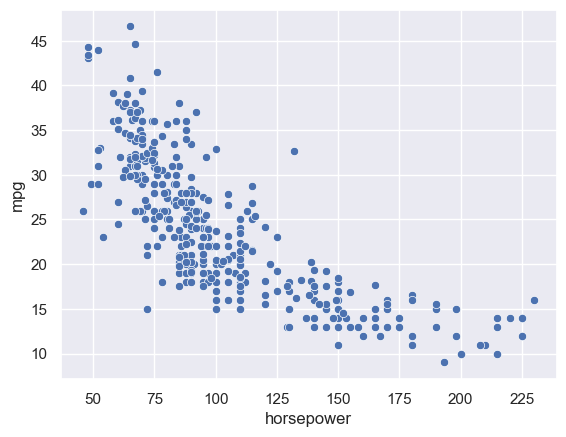

In [12]:
sns.scatterplot(data=mpg, x="horsepower", y="mpg")

If we were to plot a linear model, this would work, but it doesn't look like it fits as well as it perhaps could:

<Axes: xlabel='horsepower', ylabel='mpg'>

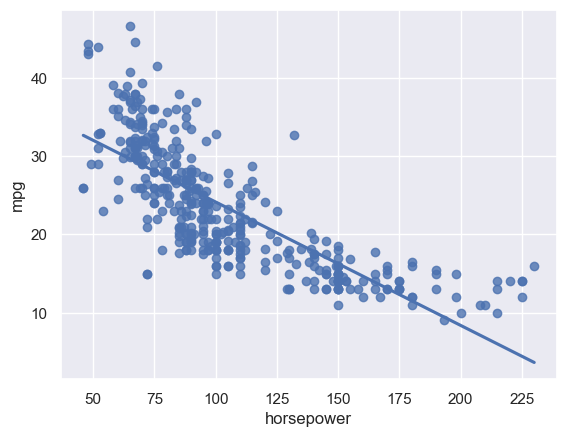

In [13]:
sns.regplot(data=mpg, x="horsepower", y="mpg", ci=None)

Instead, we could do a non-linear regression model. In seaborn, this is easy to do by passing in a higher `order` value, which corresponds to using a polynomial to model the relationship:

<Axes: xlabel='horsepower', ylabel='mpg'>

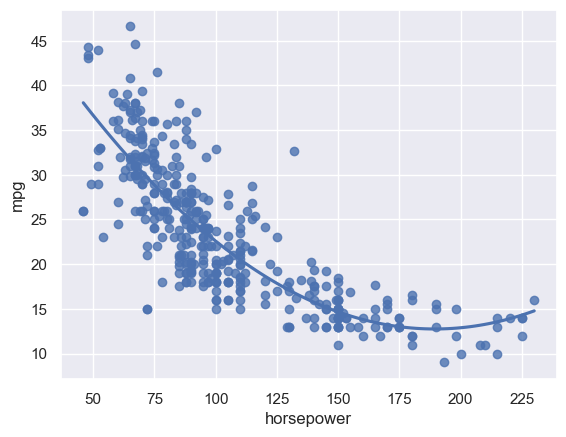

In [14]:
sns.regplot(data=mpg, x="horsepower", y="mpg", order=2, ci=None)


That looks much better. In this lab, we're not going to explore fitting a non-linear model (you can explore how to do this yourself if you're interested), but it's worth knowing that these non-linear models exist!

## Classification

In today's lectures, we also introduced classification problems, and outlined logistic regression as one method of modelling a binary response. Remember that when we use logistic regression, we're looking to predict the *probability* that the y variable is 1, using our selection of independent variables. 

Let's have a go at doing this with the Titanic dataset. Recall that this dataset has plenty of different variables, including `survived`, which is a binary outcome variable representing whether the passenger survived (`1`) or not (`0`).

In [15]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


Let's see if we can build a logistic regression model, predicting whether someone survived based on some of the other variables we have.

In other words, we're looking to calculate the probability that a person `survived`, based on the other variables:

In [16]:

titanic_new = titanic
titanic_new['pgender'] = (titanic_new['sex']=='male').astype(int)

titanic_new = titanic_new[['survived', 'age', 'pgender', 'pclass']].dropna()

titanic_logreg_x = titanic_new[['age', 'pgender', 'pclass']].values
titanic_logreg_y = titanic_new['survived'].values


titanic_logreg = linear_model.LogisticRegression().fit(titanic_logreg_x, titanic_logreg_y)


print("Intercept: ", titanic_logreg.intercept_[0]) 
print("Age Coefficient: ", titanic_logreg.coef_[0][0])
print("Gender Coefficient: ", titanic_logreg.coef_[0][1])
print("Class Coefficient: ", titanic_logreg.coef_[0][2])
print("R-Squared: ", titanic_logreg.score(titanic_logreg_x, titanic_logreg_y))


Intercept:  4.881201864738141
Age Coefficient:  -0.036123654410533904
Gender Coefficient:  -2.412269102060114
Class Coefficient:  -1.2489683276492152
R-Squared:  0.7899159663865546


Note that the previously used metrics (intercept, coefficient, and R-Squared) behave a little bit differently for logistic regression -- however, broadly speaking, we can see that: 

- An increase in age slightly decreases your chance of survival
- Being male decreases your chance of survival
- An increase in passenger class decreases your chance of survival

Let's try and predict on this model:

In [17]:
titanic_pred = titanic_logreg.predict([[25, 0, 3]])

titanic_pred[0]

1

In other words, a 25 year old female travelling third class would be predicted to survive, whereas:

In [18]:
titanic_pred = titanic_logreg.predict([[50, 1, 2]])

titanic_pred[0]

0

A 50 year old male travelling second class would not be predicted to survive.

## Exercise

Have a go at building some linear regression models and logistic regression models using some of the other datasets available. Can you find anything interesting?